# Model based analysis Risk & Ambiguity
#### Korem et al., 2023?

This notebook loads the R&A task from the aging project and uses variations of the utility function to try and model the effects of aging on forced choice lottery selection in the medical domain. 

#### Step 1 model behavior

Choices in the medical domain are quantitatively different. </br>
Using computational model we will try to see if we can estimate the value. </br>
We will test 3 models: </br>
    1. No individual parameters </br>
    2. Only ambiguity aversion </br>
    3. Both ambiguity and probability weighting 
   
#### Step 2 model age

Take the best model and check if we add age parameters

#### Step 3 validate the model using monetary data and compare it to more classical approaches

compare the qualitative model to:</br>
    1. No individual parameters</br>
    2. Classical utility function</br>
    3. "Trembling hand" model


## Step 0

### Load libraries 


In [1]:
import pandas as pd
import numpy as np

import pymc3 as pm
import arviz as az

import matplotlib.pyplot as plt
import seaborn as sns

## Load Data

In [2]:
# load demographic data
age = pd.read_csv('../demo.csv')

# load choice data
db_mon = pd.read_csv('data/mon.csv')
db_med = pd.read_csv('data/med.csv')

print('Participants monetary: ', len(db_mon['sub'].unique()), 'participants medical: ', len(db_med['sub'].unique()))

Participants monetary:  98 participants medical:  98


## Preprocessing 

In [3]:
# make a list with subjects number
s_am = list(age['sub'].unique())
s_ra = list(db_mon['sub'].unique())

# find participant in one list but not in the second
demo_no_ra = list(set(s_am)- set(s_ra))
ra_no_demo = list(set(set(s_ra)- set(s_am)))

print ('pariticpant with R&A and no MoCA:', ra_no_demo)
print ('pariticpant with MoCA and no R&A:', demo_no_ra)

age = age[age['sub'].isin(db_mon['sub'].values)]

# remove participants without age/moca from the db and add age, moca and gender
db_mon = db_mon.merge(age, left_on='sub', right_on='sub')
db_med = db_med.merge(age, left_on='sub', right_on='sub')

db_mon = db_mon[db_mon['moca_score']>25]
db_med = db_med[db_med['moca_score']>25]


print('Number of participants with all data:', len(db_med['sub'].unique()))

pariticpant with R&A and no MoCA: [64, 65, 67, 70, 12, 79, 81, 84, 21, 22, 89, 91, 31, 97, 34, 35, 98, 99, 45, 110, 47, 48, 112, 114, 53, 54, 62]
pariticpant with MoCA and no R&A: []
Number of participants with all data: 71


In [4]:
risk_min = 2 # the minimum number of trials participant chose the lottery.

# collect number of lottery selection by subject
choices_mon = db_mon[['sub','choice']].groupby(['sub']).sum()
choices_med = db_med[['sub','choice']].groupby(['sub']).sum()

# get the subject number for participant who were too risk averse
too_risk_averse_mon = list(choices_mon[choices_mon['choice']<risk_min].index)
too_risk_averse_med = list(choices_med[choices_med['choice']<risk_min].index)

print('Monetary too risk averse (', risk_min, '): ', too_risk_averse_mon)
print('Medical too risk averse (', risk_min, '): ', too_risk_averse_med)


# remove too risk averse particiants from the data frames
db_mon = db_mon[~db_mon['sub'].isin(too_risk_averse_mon)]
db_med = db_med[~db_med['sub'].isin(too_risk_averse_med)]

# compare monetary and medical lists and keep only valid participants in both
mon_s = list(db_mon['sub'].unique())
med_s = list(db_med['sub'].unique())

db_mon = db_mon[db_mon['sub'].isin(med_s)]
db_med = db_med[db_med['sub'].isin(mon_s)]

print('Subjects who were not too risk averse: ', len(db_mon['sub'].unique()), len(db_med['sub'].unique()))

Monetary too risk averse ( 2 ):  [11, 40]
Medical too risk averse ( 2 ):  []
Subjects who were not too risk averse:  69 69


In [5]:
mon_catch = db_mon[db_mon.catch >= 7]
med_catch = db_med[db_med.catch >= 7]

mon_catch_n = mon_catch['sub'].unique()
med_catch_n = med_catch['sub'].unique()

print('participants who failed catch trials: mon:', mon_catch_n,'; med:', med_catch_n)

participants who failed catch trials: mon: [ 17  27 111] ; med: [111]


In [6]:
# remove participants who failed catch trials
db_med = db_med[db_med.catch < 7]
db_mon = db_mon[db_mon.catch < 7]

mon_s = list(db_mon['sub'].unique())
med_s = list(db_med['sub'].unique())

db_mon = db_mon[db_mon['sub'].isin(med_s)]
db_med = db_med[db_med['sub'].isin(mon_s)]

print('Subjects who didn not fail attention check: ', len(db_mon['sub'].unique()), len(db_med['sub'].unique()))

Subjects who didn not fail attention check:  66 66


In [7]:
# remove missing trials
db_med = db_med.dropna()
db_med['choice'] = db_med['choice'].astype('int')

# sort dataframe based on subject, makes it easier to compare the output of the models.
db_med = db_med.sort_values('sub').reset_index(drop=True)

# add serial number for participants
db_med['subn'] = db_med['sub'].rank(method='dense').astype(int)-1

n_subs_med = db_med['subn'].unique().shape[0]
sub_idx_med = db_med.subn.tolist()

print("Final sample includ {} subjects and {} valid trials".format(n_subs_med, len(sub_idx_med)))

Final sample includ 66 subjects and 5501 valid trials


In [8]:
# remove missing trials
db_mon = db_mon.dropna()
db_mon['choice'] = db_mon['choice'].astype('int')

# sort dataframe based on subject, makes it easier to compare the output of the models.
db_mon = db_mon.sort_values('sub').reset_index(drop=True)

# add serial number for participants
db_mon['subn'] = db_mon['sub'].rank(method='dense').astype(int)-1

n_subs = db_mon['subn'].unique().shape[0]
sub_idx = db_mon.subn.tolist()

print("Final sample includ {} subjects and {} valid trials".format(n_subs, len(sub_idx)))

Final sample includ 66 subjects and 5518 valid trials


### Add categories

In [9]:
db_med['level']= db_med['value'].rank(method='dense').astype(int)

db_med['l1'] = db_med.level > 0
db_med['l2'] = db_med.level > 1
db_med['l3'] = db_med.level > 2
db_med['l4'] = db_med.level > 3

db_med['l1'] = db_med['l1'].astype(int)
db_med['l2'] = db_med['l2'].astype(int)
db_med['l3'] = db_med['l3'].astype(int)
db_med['l4'] = db_med['l4'].astype(int)

In [10]:
db_mon['level']= db_mon['value'].rank(method='dense').astype(int)

db_mon['l1'] = db_mon.level > 0
db_mon['l2'] = db_mon.level > 1
db_mon['l3'] = db_mon.level > 2
db_mon['l4'] = db_mon.level > 3

db_mon['l1'] = db_mon['l1'].astype(int)
db_mon['l2'] = db_mon['l2'].astype(int)
db_mon['l3'] = db_mon['l3'].astype(int)
db_mon['l4'] = db_mon['l4'].astype(int)

### Final sample descriptives

Total: 66 
Females:  30


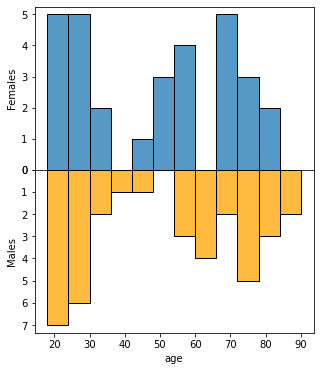

In [11]:
participants = db_mon.drop_duplicates(['sub'])
fig, ax = plt.subplots(2, 1, figsize=(5, 6),sharex=True)

sns.histplot(participants[participants['gender']=='F']['age'], binwidth=6, ax=ax[0])
sns.histplot(participants[participants['gender']=='M']['age'], binwidth=6, color='orange', ax=ax[1])

ax[0].set(ylabel='Females', xlabel='')
ax[1].set(ylabel='Males')
ax[1].invert_yaxis()

plt.subplots_adjust(wspace=0, hspace=0)
print("Total:", participants.shape[0], "\nFemales: ", participants[participants['gender']=='F'].shape[0])

## Step 1 Modeling medical decisions

### Model 1: no individual parameters

In [12]:
with pm.Model() as M_RiskAmb_simple:
    
    # hyper priors
    gMu = pm.Normal('gMu',  0, 1)
    gSig = pm.Gamma('gSig', 2, 1)
   
    γ = pm.Lognormal('γ', gMu, gSig, shape = n_subs_med)
      
    # Expected value of outcome
    val  = db_med['value'].values
    prob = db_med['risk'].values - (db_med['ambiguity'].values/2)
    
    svLotto = val * prob
    svRef   = 1
    
    p  = (svLotto - svRef)/γ[sub_idx_med]
    mu = pm.invlogit(p)
       
    # Likelihood (sampling distribution) of observations
    choice = pm.Binomial('choice',1, mu, observed=db_med['choice'])
    
    med_simple = pm.sample(tune=2000, draws=2000, return_inferencedata=True, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [γ, gSig, gMu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 69 seconds.


### Model 2: Unique values

In [13]:
with pm.Model() as med_estimated:
    
    # hyper parameters
    gMu  = pm.Normal('gMu', 0, 1)
    gSig = pm.Gamma('gSig', 2, 1)
    
    bMu  = pm.Normal('bMu', .65, 1)
    bSig = pm.Gamma('bSig', 2,  1)
    
    # Priors
    β = pm.TruncatedNormal('β', bMu, bSig, lower = -1.5, upper = 1.5, shape = n_subs_med)
    γ = pm.Lognormal('γ',       gMu, gSig,                            shape = n_subs_med)
    
    # to avoid the increasing the mean or the SD we sampled each category seperatly and sumed them up
    level1 = pm.Normal('level1', 1, 1, shape = n_subs_med)
    level2 = pm.Normal('level2', 1, 1, shape = n_subs_med)
    level3 = pm.Normal('level3', 1, 1, shape = n_subs_med)
    level4 = pm.Normal('level4', 1, 1, shape = n_subs_med)
      
    # Expected value of outcome
    val = (db_med['l1'].values * level1[sub_idx_med] + 
           db_med['l2'].values * level2[sub_idx_med] + 
           db_med['l3'].values * level3[sub_idx_med] + 
           db_med['l4'].values * level4[sub_idx_med]
          )   
    
    # risk and ambiguity calculation
    prob = (db_med['risk'].values) - (β[sub_idx_med] * (db_med['ambiguity'].values/2))  
    
    svLotto = val * prob
    svRef   = level1[sub_idx_med] 
    
    p  = (svLotto - svRef)/γ[sub_idx_med]
    mu = pm.invlogit(p)
       
    # Likelihood (sampling distribution) of observations
    choice = pm.Binomial('choice',1, mu, observed=db_med['choice'])
    
    med_estimated = pm.sample(tune=2000, draws=2000, return_inferencedata=True, target_accept=0.99)

WARNING (theano.tensor.opt): Optimization Warning: The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [level4, level3, level2, level1, γ, β, bSig, bMu, gSig, gMu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1557 seconds.
The number of effective samples is smaller than 25% for some parameters.


### Compare models

In [14]:
compare_dict = {
    "No subjective attitudes": med_simple, 
    "Estimated Values": med_estimated}

comp = az.compare(compare_dict)
comp

/home/nachshon/anaconda3/envs/risk/lib/python3.8/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/nachshon/anaconda3/envs/risk/lib/python3.8/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Estimated Values,0,-1411.351115,249.089657,0.00000,0.985106,44.922919,0.000000,True,log
No subjective attitudes,1,-2930.400986,47.201304,1519.04987,0.014894,32.225340,42.753244,True,log


### Save models

In [15]:
med_simple.to_netcdf("data/med_simple.nc")
med_estimated.to_netcdf('data/med_estimated.nc')

'data/med_estimated.nc'

## Step 2 adding age

### Model 3: Age is associated with ambiguity, value and probability weighting

In [16]:
with pm.Model() as M_RiskAmb_estimated_age:

    # hyper parameters
    gMu  = pm.Normal('gMu', 0, 1)
    gSig = pm.Gamma('gSig', 2, 1)
    
    bMu  = pm.Normal('bMu', .65, 1)
    bSig = pm.Gamma('bSig', 2,  1)

    # Priors
    β = pm.TruncatedNormal('β',  bMu, bSig, lower = -1.5, upper = 1.5, shape = n_subs_med)
    γ = pm.Lognormal('γ',        gMu, gSig,                            shape = n_subs_med)
    
    level1 = pm.Normal('level1', 1, 1, shape = n_subs_med)
    level2 = pm.Normal('level2', 1, 1, shape = n_subs_med)
    level3 = pm.Normal('level3', 1, 1, shape = n_subs_med)
    level4 = pm.Normal('level4', 1, 1, shape = n_subs_med)
    
    # Age priors
    AgeV = pm.Normal('Age-Value',    0, 1)
    AgeA = pm.Normal('Age-Ambiguty', 0, 1)
      
    # Expected value of outcome
    val = (db_med['l1'].values * level1[sub_idx_med] + 
           db_med['l2'].values * level2[sub_idx_med] + 
           db_med['l3'].values * level3[sub_idx_med] + 
           db_med['l4'].values * level4[sub_idx_med]
          ) + AgeV * db_med['age'].values/100
    
    # risk and ambiguity calculation
    amb  = β[sub_idx_med] + AgeA * db_med['age'].values/100
    
    prob = db_med['risk'].values - (amb * (db_med['ambiguity'].values/2))
        
    svLotto = val * prob
    svRef = level1[sub_idx_med] + AgeV * db_med['age'].values/100
    
    p  = (svLotto - svRef)/γ[sub_idx_med]
    mu = pm.invlogit(p)
       
    # Likelihood (sampling distribution) of observations
    choice = pm.Binomial('choice',1, mu, observed=db_med['choice'])
    
    med_estimated_age = pm.sample(tune=2000, draws=2000, return_inferencedata=True, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Age-Ambiguty, Age-Value, level4, level3, level2, level1, γ, β, bSig, bMu, gSig, gMu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1930 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [17]:
az.summary(med_estimated_age,var_names=['Age-Ambiguty', 'Age-Value'], hdi_prob=.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Age-Ambiguty,-0.092,0.236,-0.485,0.269,0.009,0.007,620.0,1005.0,1.01
Age-Value,0.427,0.254,0.021,0.827,0.006,0.004,1986.0,3649.0,1.00


#### Save model

In [18]:
med_estimated_age.to_netcdf("data/med_estimated_age.nc")

'data/med_estimated_age.nc'

## Step 3 validating the models using monetary decision making

### Model 4: no subjective values

In [19]:
with pm.Model() as RiskAmb_free:

    # priors
    gMu  = pm.Normal('gMu', 0, 1)
    gSig = pm.Gamma('gSig', 2, 1)

    γ = pm.Lognormal('γ', gMu , gSig, shape = n_subs)
      
    # Expected value of outcome
    prob = (db_mon['risk'].values - (db_mon['ambiguity'].values/2))
    
    svLotto = db_mon['value'].values * prob
    svRef   = 5
    
    p  = (svLotto - svRef)/γ[sub_idx]
    mu = pm.invlogit(p)
       
    # Likelihood (sampling distribution) of observations
    choice = pm.Binomial('choice',1, mu, observed=db_mon['choice'])
    
    mon_free = pm.sample(tune=2000, draws=2000, return_inferencedata=True, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [γ, gSig, gMu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 69 seconds.


### Model 5: utility function

In [20]:
with pm.Model() as RiskAmb_beta:
    # Hyper Priors
    alpha_a = pm.TruncatedNormal('alpha_a', 4, 1, lower = 1)
    alpha_b = pm.TruncatedNormal('alpha_b', 7, 1, lower = 1)
    
    gMu  = pm.Normal('gMu', 0, 1)
    gSig = pm.Gamma('gSig', 2, 1)
    
    bMu  = pm.Normal('bMu', .65, 1)
    bSig = pm.Gamma('bSig', 2,  1)
    
    # Priors
    alpha = pm.Beta('alpha', alpha_a, alpha_b, shape = n_subs)
    α = pm.Deterministic('α', alpha * 2)
    
    β = pm.TruncatedNormal('β',  bMu, bSig, lower = -1.5, upper = 1.5, shape = n_subs)
    γ = pm.Lognormal('γ',        gMu, gSig,                            shape = n_subs)
    
          
    # Expected value of outcome
    value = db_mon['value'].values ** α[sub_idx]
    prob  = db_mon['risk'].values - (β[sub_idx] * (db_mon['ambiguity'].values/2))
    
    svLotto = value * prob
    svRef   = 5 ** α[sub_idx]
                                     
    p  = (svLotto - svRef)/γ[sub_idx]
    mu = pm.invlogit(p)
       
    # Likelihood (sampling distribution) of observations
    choice = pm.Binomial('choice',1, mu, observed=db_mon['choice'])

    mon_beta = pm.sample(tune=2000, draws=2000, return_inferencedata=True, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [γ, β, alpha, bSig, bMu, gSig, gMu, alpha_b, alpha_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 619 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


### Model 6: "Trembling hand" model

In [21]:
with pm.Model() as RiskAmb_trembel:
    # Hyper Priors
    alpha_a = pm.TruncatedNormal('alpha_a', 4, 1, lower = 1)
    alpha_b = pm.TruncatedNormal('alpha_b', 7, 1, lower = 1)
    
    g_a = pm.TruncatedNormal('g_a', 2, 1, lower = 1)
    g_b = pm.TruncatedNormal('g_b', 2, 1, lower = 1)
    
    bMu  = pm.Normal('bMu', .65,   1)
    bSig = pm.Gamma('bSig', 2, 1)

    # Priors
    alpha = pm.Beta('alpha', alpha_a, alpha_b, shape = n_subs)
    α = pm.Deterministic('α', alpha * 2)
    
    β = pm.TruncatedNormal('β',  bMu, bSig, lower = -1.5, upper = 1.5, shape = n_subs)
       
    # Expected value of outcome
    value = db_mon['value'].values ** α[sub_idx]
    prob  = db_mon['risk'].values  - (β[sub_idx] * (db_mon['ambiguity'].values/2))
    
    svLotto = value * prob
    svRef = 5 ** α[sub_idx]
                                
    γ = pm.Beta('γ', g_a, g_b, shape = n_subs)

    # Expected value of outcome
    prob = db_mon['risk'].values - (β[sub_idx] * (db_mon['ambiguity'].values/2))
    val = db_mon['value'].values ** α[sub_idx]
            
    svLotto =  val * prob
    svRef = 5 ** α[sub_idx]
    p = (1/(1+np.exp(-(svLotto - svRef))))*(1-γ[sub_idx])+γ[sub_idx]*.5

    # Likelihood (sampling distribution) of observations
    choice = pm.Binomial('choice',1, p, observed=db_mon['choice'])

    mon_hand = pm.sample(tune=2000, draws=2000, return_inferencedata=True, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [γ, β, alpha, bSig, bMu, g_b, g_a, alpha_b, alpha_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 629 seconds.
The number of effective samples is smaller than 10% for some parameters.


### Model 7: Unique values

In [22]:
with pm.Model() as RiskAmb_estimated_mon:
    
    # hyper parameters
    bMu  = pm.Normal('bMu', .65, 1)
    bSig = pm.Gamma('bSig', 2,  1)
    
    gMu  = pm.Normal('gMu', 0, 1)
    gSig = pm.Gamma('gSig', 2, 1)
    
    # Priors
    γ = pm.Lognormal('γ',       gMu, gSig,                            shape = n_subs)
    β = pm.TruncatedNormal('β', bMu, bSig, lower = -1.5, upper = 1.5, shape = n_subs)

    
    level1 = pm.Normal('level1', 1, 1, shape = n_subs)
    level2 = pm.Normal('level2', 1, 1, shape = n_subs)
    level3 = pm.Normal('level3', 1, 1, shape = n_subs)
    level4 = pm.Normal('level4', 1, 1, shape = n_subs)
      
    # Expected value of outcome
    val = (db_mon['l1'].values * level1[sub_idx] + 
           db_mon['l2'].values * level2[sub_idx] + 
           db_mon['l3'].values * level3[sub_idx] + 
           db_mon['l4'].values * level4[sub_idx]
          )   
        
    # risk and ambiguity calculation
    prob  = db_mon['risk'].values - (β[sub_idx] * (db_mon['ambiguity'].values/2))
    
    svLotto = val * prob
    svRef   = level1[sub_idx] 
    
    p  = (svLotto - svRef)/γ[sub_idx]
    mu = pm.invlogit(p)
       
    # Likelihood (sampling distribution) of observations
    choice = pm.Binomial('choice',1, mu, observed=db_mon['choice'])
    
    mon_estimated = pm.sample(tune=2000, draws=2000, return_inferencedata=True, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [level4, level3, level2, level1, β, γ, gSig, gMu, bSig, bMu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1621 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


#### compare models

In [23]:
compare_dict = {'simple model': mon_free, 
                'Classic Utility': mon_beta,
                'Trembling-hand': mon_hand, 
                'Estimated values': mon_estimated
}

comp = az.compare(compare_dict)
comp

/home/nachshon/anaconda3/envs/risk/lib/python3.8/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/nachshon/anaconda3/envs/risk/lib/python3.8/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/nachshon/anaconda3/envs/risk/lib/pyt

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Estimated values,0,-1562.257574,259.854913,0.000000,9.280901e-01,45.987935,0.000000,True,log
Classic Utility,1,-1833.580130,181.288085,271.322555,9.850873e-13,45.154320,25.243382,True,log
Trembling-hand,2,-1977.037895,136.310295,414.780320,7.190994e-02,36.577556,31.747156,True,log
simple model,3,-2618.234341,59.146018,1055.976767,0.000000e+00,38.232897,41.801779,True,log


#### Save models

In [24]:
mon_free.to_netcdf("data/mon_free.nc")
mon_beta.to_netcdf('data/mon_beta.nc')
mon_hand.to_netcdf('data/mon_hand.nc')
mon_estimated.to_netcdf('data/mon_estimated.nc')

'data/mon_estimated.nc'

## Step 4: test age in the winning model

### Model 8: Unique values with probability weighting and age

In [25]:
with pm.Model() as RiskAmb_unique_mon_age:
    
    # hyper parameters
    bMu  = pm.Normal('bMu', .65, 1)
    bSig = pm.Gamma('bSig', 2,  1)
    
    gMu  = pm.Normal('gMu', 0, 1)
    gSig = pm.Gamma('gSig', 2, 1)
    
    # Priors
    β = pm.TruncatedNormal('β',  bMu, bSig, lower = -1.5, upper = 1.5, shape = n_subs)
    γ = pm.Lognormal('γ',        gMu, gSig,                            shape = n_subs)
    
    # Age priors
    AgeV = pm.Normal('Age-Value',    0, 1)
    AgeA = pm.Normal('Age-Ambiguty', 0, 1)
      
    level1 = pm.Normal('level1', 1, 1, shape = n_subs)
    level2 = pm.Normal('level2', 1, 1, shape = n_subs)
    level3 = pm.Normal('level3', 1, 1, shape = n_subs)
    level4 = pm.Normal('level4', 1, 1, shape = n_subs)
      
    # Expected value of outcome
    val = (db_mon['l1'].values * level1[sub_idx] + 
           db_mon['l2'].values * level2[sub_idx] + 
           db_mon['l3'].values * level3[sub_idx] + 
           db_mon['l4'].values * level4[sub_idx]
          ) + AgeV * db_mon['age'].values/100
    
    amb  = β[sub_idx] + AgeA * db_mon['age'].values/100
    
    prob  = db_mon['risk'].values - (amb * (db_mon['ambiguity'].values/2))
    
    svLotto = val * prob
    svRef = level1[sub_idx] + AgeV * db_mon['age'].values/100
    
    p  = (svLotto - svRef)/γ[sub_idx]
    mu = pm.invlogit(p)
       
    # Likelihood (sampling distribution) of observations
    choice = pm.Binomial('choice',1, mu, observed=db_mon['choice'])
    
    mon_estimated_age = pm.sample(tune=2000, draws=2000, return_inferencedata=True, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [level4, level3, level2, level1, Age-Ambiguty, Age-Value, γ, β, gSig, gMu, bSig, bMu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2045 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [26]:
az.summary(mon_estimated_age, var_names=['Age-Ambiguty', 'Age-Value'], hdi_prob=.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Age-Ambiguty,-0.181,0.218,-0.522,0.180,0.009,0.006,559.0,1294.0,1.01
Age-Value,0.843,0.261,0.433,1.261,0.005,0.003,3352.0,4743.0,1.00


### save model

In [27]:
mon_estimated_age.to_netcdf("data/mon_estimated_age.nc")

'data/mon_estimated_age.nc'

### Plot Estimated values

In [28]:
# get subjects data
df = db_med[['sub','age', 'gender', 'moca_score']].sort_values('sub').drop_duplicates().reset_index(drop=True)
df['age'] = df.age.astype('int')

# extract parameters from the model
level1 = az.summary(med_estimated, var_names=['level1'])[['mean','sd']]
level2 = az.summary(med_estimated, var_names=['level2'])[['mean','sd']]
level3 = az.summary(med_estimated, var_names=['level3'])[['mean','sd']]
level4 = az.summary(med_estimated, var_names=['level4'])[['mean','sd']]
beta = az.summary(  med_estimated, var_names=['β']     )[['mean','sd']]

# change column names
level1 = level1.rename(columns={'mean': "level1_med",'sd': "level1_sd_med"}).reset_index(drop=True)
level2 = level2.rename(columns={'mean': "level2_med",'sd': "level2_sd_med"}).reset_index(drop=True)
level3 = level3.rename(columns={'mean': "level3_med",'sd': "level3_sd_med"}).reset_index(drop=True)
level4 = level4.rename(columns={'mean': "level4_med",'sd': "level4_sd_med"}).reset_index(drop=True)
beta   = beta.rename(  columns={'mean': "beta_med",  'sd': "beta_sd_med"}).reset_index(drop=True)

# combine to a single dataframe
df = df.merge(level1, left_index=True, right_index=True)
df = df.merge(level2, left_index=True, right_index=True)
df = df.merge(level3, left_index=True, right_index=True)
df = df.merge(level4, left_index=True, right_index=True)
df = df.merge(beta,   left_index=True, right_index=True)

# calculate the SV of each level
df['level1'] = df['level1_med']
df['level2'] = df['level1'] + df['level2_med']
df['level3'] = df['level2'] + df['level3_med']
df['level4'] = df['level3'] + df['level4_med']

In [29]:
df_long_med = df.melt(id_vars='sub',
                      value_vars=['level1', 'level2', 'level3', 'level4'], 
                      var_name='level')

hist = db_med.groupby(['sub','level','risk','ambiguity']).sum()['choice']
hist = hist.reset_index()


hist['risk'] = hist.risk.astype('category')
hist['ambiguity'] = hist.ambiguity.astype('category')
hist['level'] = hist.level.astype('category')

print("Levels Mean: ", 
      np.mean(df['level1_med']), 
      np.mean(df['level2_med']),
      np.mean(df['level3_med']),
      np.mean(df['level4_med']))

print("Levels SD: ", 
      np.std(df['level1_med']), 
      np.std(df['level2_med']),
      np.std(df['level3_med']),
      np.std(df['level4_med']))

level_mapping = {
    'level1': 'Slight',
    'level2': 'Moderate',
    'level3': 'Major',
    'level4': 'Complete recovery'
}

df_long_med['levelName'] = df_long_med['level'].map(level_mapping)

Levels Mean:  1.226757575757576 1.5458333333333334 1.1559242424242426 0.8512575757575757
Levels SD:  0.5898441258041298 0.5905554032801955 0.7021215104758656 0.686636296267317


In [30]:
# get subjects data
df = db_mon[['sub','age', 'gender', 'moca_score']].sort_values('sub').drop_duplicates().reset_index(drop=True)
df['age'] = df.age.astype('int')

# extract parameters from the model
level1 = az.summary(mon_estimated, var_names=['level1'])[['mean','sd']]
level2 = az.summary(mon_estimated, var_names=['level2'])[['mean','sd']]
level3 = az.summary(mon_estimated, var_names=['level3'])[['mean','sd']]
level4 = az.summary(mon_estimated, var_names=['level4'])[['mean','sd']]
beta   = az.summary(mon_estimated, var_names=['β']     )[['mean','sd']]

# change column names
level1 = level1.rename(columns={'mean': "level1_mon",'sd': "level1_sd_mon"}).reset_index(drop=True)
level2 = level2.rename(columns={'mean': "level2_mon",'sd': "level2_sd_mon"}).reset_index(drop=True)
level3 = level3.rename(columns={'mean': "level3_mon",'sd': "level3_sd_mon"}).reset_index(drop=True)
level4 = level4.rename(columns={'mean': "level4_mon",'sd': "level4_sd_mon"}).reset_index(drop=True)
beta   = beta.rename(  columns={'mean': "beta_mon",  'sd': "beta_sd_mon"}  ).reset_index(drop=True)

# combine to a single dataframe
df = df.merge(level1, left_index=True, right_index=True)
df = df.merge(level2, left_index=True, right_index=True)
df = df.merge(level3, left_index=True, right_index=True)
df = df.merge(level4, left_index=True, right_index=True)
df = df.merge(beta,   left_index=True, right_index=True)

# calculate the SV of each level
df['level1'] = df['level1_mon']
df['level2'] = df['level1'] + df['level2_mon']
df['level3'] = df['level2'] + df['level3_mon']
df['level4'] = df['level3'] + df['level4_mon']

In [31]:
df_long_mon = df.melt(id_vars='sub',
                      value_vars=['level1', 'level2', 'level3', 'level4'],
                      var_name='level')

hist = db_mon.groupby(['sub','level','risk','ambiguity']).sum()['choice']
hist = hist.reset_index()


hist['risk'] = hist.risk.astype('category')
hist['ambiguity'] = hist.ambiguity.astype('category')
hist['level'] = hist.level.astype('category')

print("Levels Mean: ", 
      np.mean(df['level1_mon']), 
      np.mean(df['level2_mon']),
      np.mean(df['level3_mon']),
      np.mean(df['level4_mon']))

print("Levels SD: ", 
      np.std(df['level1_mon']), 
      np.std(df['level2_mon']),
      np.std(df['level3_mon']),
      np.std(df['level4_mon']))

level_mapping = {
    'level1': 5,
    'level2': 8,
    'level3': 12,
    'level4': 25
}

df_long_mon['levelName'] = df_long_mon['level'].map(level_mapping)

Levels Mean:  1.3892727272727274 0.8180151515151516 1.147 1.3676060606060607
Levels SD:  0.4774016968605047 0.7275782055731034 0.7154204951275054 0.7850474774059534


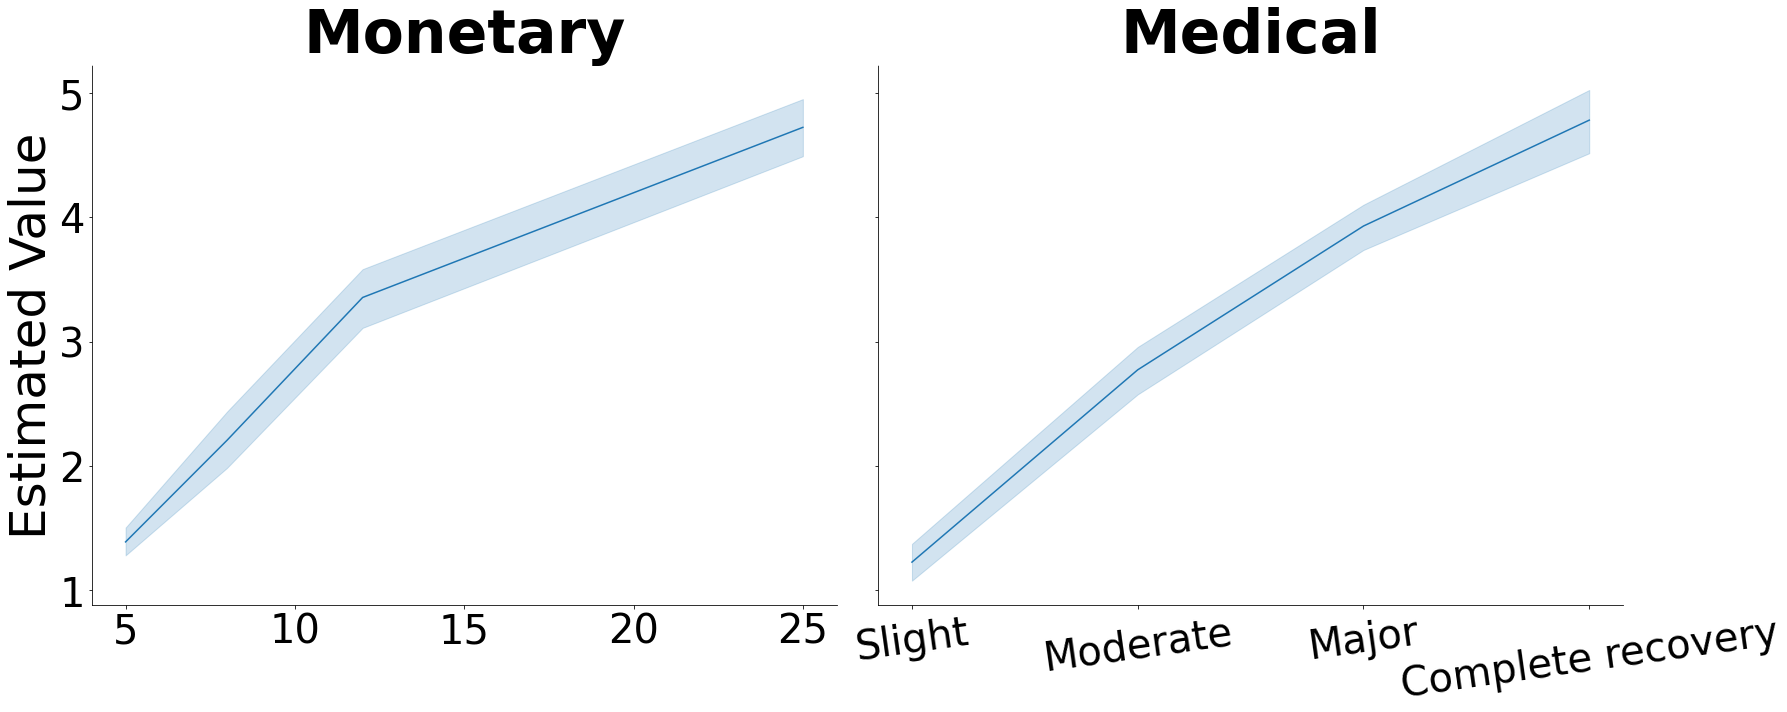

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(25, 10), sharey=True)
sns.lineplot(data = df_long_mon, x = 'levelName', y='value', ax=axes[0])
sns.lineplot(data = df_long_med, x = 'levelName', y='value', ax=axes[1])


#axes[1].set(ylabel="Estimated Value")
axes[0].set_title('Monetary', fontweight="bold", size=60)
axes[1].set_title('Medical', fontweight="bold", size=60)
axes[0].set_ylabel('Estimated Value', fontsize = 50.0)
axes[0].set_xlabel('', fontsize = 50.0)
axes[1].set_xlabel('', fontsize = 50.0)
axes[0].tick_params(axis='both', which='major', labelsize=40)
axes[1].tick_params(axis='both', which='major', labelsize=40)
axes[1].tick_params(axis='x', labelrotation=8)


axes[0].set_facecolor('White')
axes[1].set_facecolor('White')

for spine in ['right', 'top']:
    axes[0].spines[spine].set_color('white')
    axes[1].spines[spine].set_color('white')
    
fig.tight_layout()


In [33]:
with pm.Model() as RiskAmb_beta_fixed_age:
    # Hyper Priors
    alpha_a = pm.TruncatedNormal('alpha_a', 4, 1, lower = 1)
    alpha_b = pm.TruncatedNormal('alpha_b', 7, 1, lower = 1)
    
    gMu  = pm.Normal('gMu', 0, 1)
    gSig = pm.Gamma('gSig', 2, 1)
    
    bMu  = pm.Normal('bMu', .65, 1)
    bSig = pm.Gamma('bSig', 2,  1)
    
    # Priors
    alpha = pm.Beta('alpha', alpha_a, alpha_b)
    age_a = pm.Normal('age_a', 0, 1)
    
    α = pm.Deterministic('α', alpha * 2)
    
    
    β = pm.TruncatedNormal('β',  bMu, bSig, lower = -1.5, upper = 1.5)
    age_b = pm.Normal('age_b', 0, 1)
    
    γ = pm.Lognormal('γ', gMu, gSig)
    
          
    # Expected value of outcome
    risk  = α + db_mon['age'].values/100 * age_a
    amb   = β + db_mon['age'].values/100 * age_b
    value = db_mon['value'].values ** risk
    prob  = db_mon['risk'].values - (amb * (db_mon['ambiguity'].values/2))
    
    svLotto = value * prob
    svRef   = 5 ** risk
                                     
    p  = (svLotto - svRef)/γ
    mu = pm.invlogit(p)
       
    # Likelihood (sampling distribution) of observations
    choice = pm.Binomial('choice',1, mu, observed=db_mon['choice'])

    mon_beta_const_age = pm.sample(tune=2000, draws=2000, return_inferencedata=True, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [γ, age_b, β, age_a, alpha, bSig, bMu, gSig, gMu, alpha_b, alpha_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 273 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


In [34]:
az.summary(mon_beta_const_age, var_names=['age_a','age_b'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
age_a,-0.164,0.036,-0.233,-0.098,0.001,0.000,4565.0,5237.0,1.0
age_b,-0.371,0.105,-0.562,-0.170,0.002,0.001,4222.0,5152.0,1.0
